In [1]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam, RMSprop, SGD
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

2025-05-07 17:46:30.927923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 17:46:30.939198: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 17:46:30.950305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746636390.968532  365635 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746636390.973598  365635 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746636390.987812  365635 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Loading the dataset and preparing it for training
train_path = '../dataset_organized/train/'
test_path = '../dataset_organized/test/'

# Loading the dataset
import os
import cv2
from tqdm import tqdm

def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One hot encoding the target variable
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Splitting the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

100%|██████████| 29/29 [00:00<00:00, 1819.95it/s]


Trial 20 Complete [00h 06m 09s]
val_accuracy: 0.48022598028182983

Best val_accuracy So Far: 0.5847457647323608
Total elapsed time: 02h 00m 21s

The hyperparameter search is complete. The optimal number of convolutional layers is 4,
the optimal number of filters for each layer and corresponding kernel sizes and activations are:
- Layer 1: 64 filters, kernel size 3, activation tanh
- Layer 2: 96 filters, kernel size 5, activation relu
- Layer 3: 32 filters, kernel size 3, activation relu
- Layer 4: 32 filters, kernel size 3, activation tanh
the optimal number of units in the dense layer is 192,
the optimal activation function for the dense layer is relu,
the optimal dropout rate is 0.30000000000000004,
and the optimal optimizer and learning rate are rmsprop with a learning rate of 0.001.

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 740ms/step - accuracy: 0.1743 - loss: 2.0384 - val_accuracy: 0.2090 - val_loss: 1.8381
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 732ms/step - accuracy: 0.2757 

Training Accuracy: 0.7298443913459778
Validation Accuracy: 0.48022598028182983
Training Loss: 0.7163071036338806
Validation Loss: 1.4435545206069946


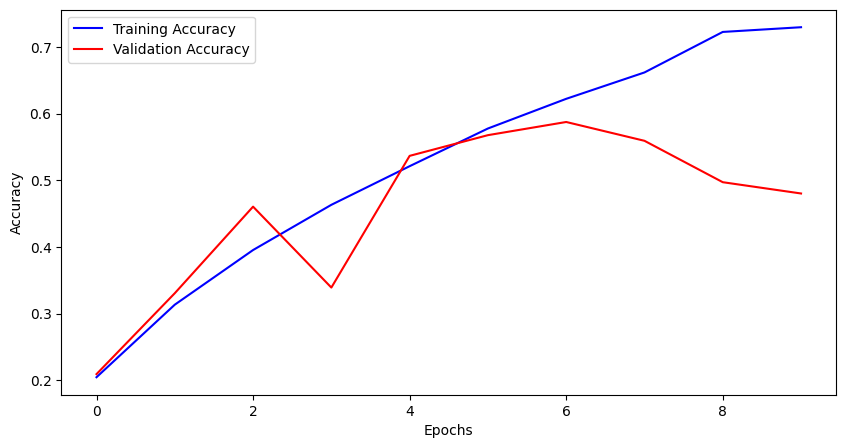

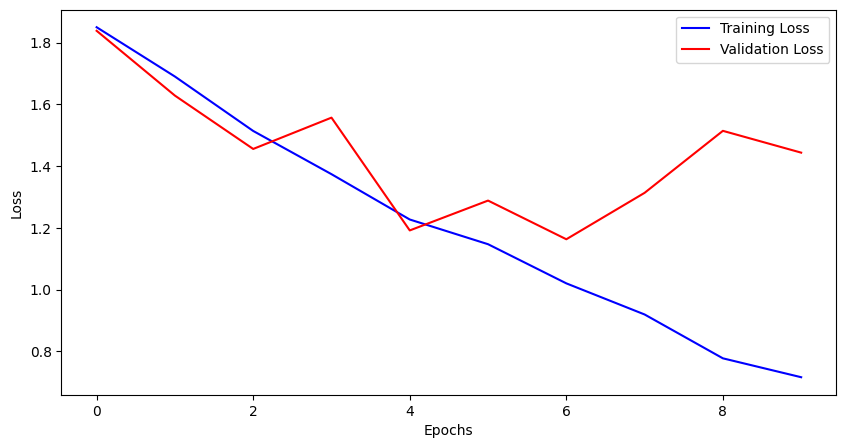

In [3]:
def build_model(hp):
    model = Sequential()
    
    # Number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=2, max_value=4)
    
    for i in range(num_conv_layers):
        filters = hp.Int(f'conv_{i+1}_filters', min_value=32, max_value=128, step=32)
        kernel_size = hp.Choice(f'conv_{i+1}_kernel_size', values=[3, 5])
        activation = hp.Choice(f'conv_{i+1}_activation', values=['relu', 'tanh'])
        
        if i == 0:
            model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(150, 150, 3)))
        else:
            model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation))
        model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    
    # Dense layer
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    model.add(Dense(units=dense_units, activation=hp.Choice('dense_activation', values=['relu', 'tanh'])))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(6, activation='softmax'))
    
    # Optimizer
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer == 'adam':
        opt = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    else:
        opt = SGD(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per combination
    directory='my_dir',
    project_name='cnn_hyperparameter_tuning'
)

tuner.search_space_summary()

# Assuming you have already loaded your data into X_train, y_train, X_val, y_val
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of convolutional layers is {best_hps.get('num_conv_layers')},
the optimal number of filters for each layer and corresponding kernel sizes and activations are:
- Layer 1: {best_hps.get('conv_1_filters')} filters, kernel size {best_hps.get('conv_1_kernel_size')}, activation {best_hps.get('conv_1_activation')}
- Layer 2: {best_hps.get('conv_2_filters')} filters, kernel size {best_hps.get('conv_2_kernel_size')}, activation {best_hps.get('conv_2_activation')}
{'' if best_hps.get('num_conv_layers') < 3 else f'- Layer 3: {best_hps.get("conv_3_filters")} filters, kernel size {best_hps.get("conv_3_kernel_size")}, activation {best_hps.get("conv_3_activation")}'}
{'' if best_hps.get('num_conv_layers') < 4 else f'- Layer 4: {best_hps.get("conv_4_filters")} filters, kernel size {best_hps.get("conv_4_kernel_size")}, activation {best_hps.get("conv_4_activation")}'}
the optimal number of units in the dense layer is {best_hps.get('dense_units')},
the optimal activation function for the dense layer is {best_hps.get('dense_activation')},
the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal optimizer and learning rate are {best_hps.get('optimizer')} with a learning rate of {best_hps.get('learning_rate')}.
""")

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Save the best model
model.save('hypertuning_cnn_model.h5')

print('Training Accuracy:', history.history['accuracy'][-1])
print('Validation Accuracy:', history.history['val_accuracy'][-1])

print('Training Loss:', history.history['loss'][-1])
print('Validation Loss:', history.history['val_loss'][-1])

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The hyperparameter search is complete. The optimal number of convolutional layers is 4,
the optimal number of filters for each layer and corresponding kernel sizes and activations are:
- Layer 1: 64 filters, kernel size 3, activation tanh
- Layer 2: 96 filters, kernel size 5, activation relu
- Layer 3: 32 filters, kernel size 3, activation relu
- Layer 4: 32 filters, kernel size 3, activation tanh
the optimal number of units in the dense layer is 192,
the optimal activation function for the dense layer is relu,
the optimal dropout rate is 0.30000000000000004,
and the optimal optimizer and learning rate are with a learning rate of 0.001.

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 813ms/step - accuracy: 0.1944 - loss: 1.9281 - val_accuracy: 0.3136 - val_loss: 1.5784
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 802ms/step - accuracy: 0.3248 - loss: 1.6355 - val_accuracy: 0.3644 - val_loss: 1.5933
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 799ms/step - accuracy: 0.3637 - loss: 1.5986 - val_ac

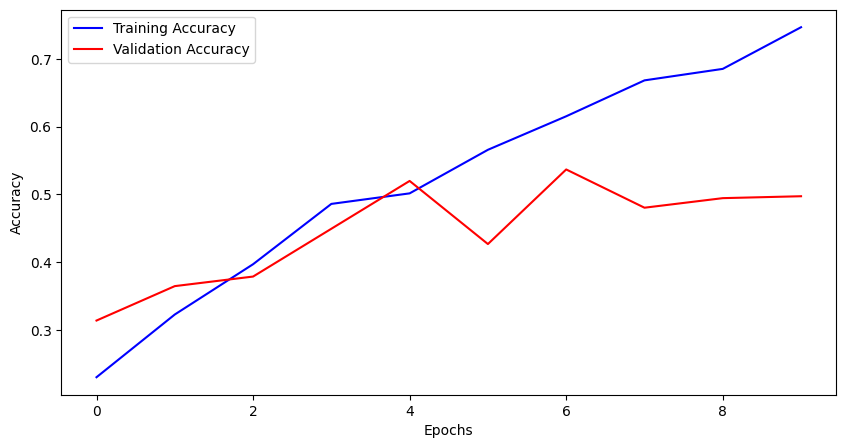

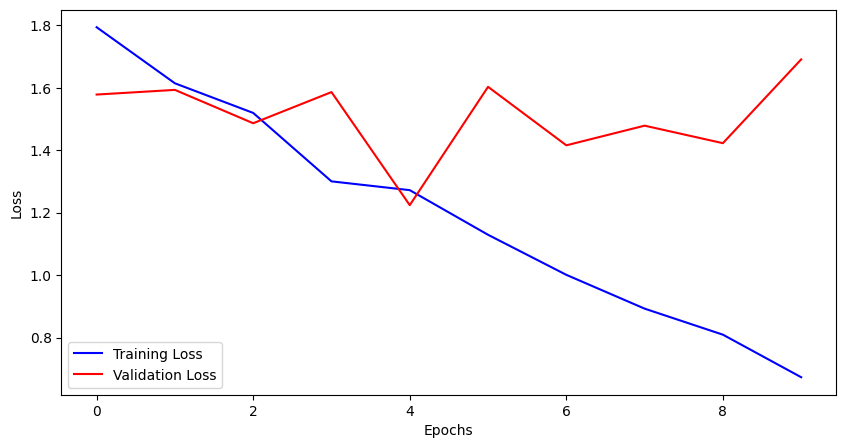

In [4]:

print(f"""
The hyperparameter search is complete. The optimal number of convolutional layers is {best_hps.get('num_conv_layers')},
the optimal number of filters for each layer and corresponding kernel sizes and activations are:
- Layer 1: {best_hps.get('conv_1_filters')} filters, kernel size {best_hps.get('conv_1_kernel_size')}, activation {best_hps.get('conv_1_activation')}
- Layer 2: {best_hps.get('conv_2_filters')} filters, kernel size {best_hps.get('conv_2_kernel_size')}, activation {best_hps.get('conv_2_activation')}
{'' if best_hps.get('num_conv_layers') < 3 else f'- Layer 3: {best_hps.get("conv_3_filters")} filters, kernel size {best_hps.get("conv_3_kernel_size")}, activation {best_hps.get("conv_3_activation")}'}
{'' if best_hps.get('num_conv_layers') < 4 else f'- Layer 4: {best_hps.get("conv_4_filters")} filters, kernel size {best_hps.get("conv_4_kernel_size")}, activation {best_hps.get("conv_4_activation")}'}
the optimal number of units in the dense layer is {best_hps.get('dense_units')},
the optimal activation function for the dense layer is {best_hps.get('dense_activation')},
the optimal dropout rate is {best_hps.get('dropout_rate')},
and the optimal optimizer and learning rate are with a learning rate of {best_hps.get('learning_rate')}.
""")

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Save the best model
model.save('hypertuning_cnn_model.h5')

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# Loading the model
from keras.models import load_model
model = load_model('hypertuning_cnn_model.h5')

# Evaluating the model
predictions = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.5399 - loss: 1.5075
Test Loss: 1.8508204221725464
Test Accuracy: 0.45939674973487854


F1 Score:  0.44635171869910795
Precision:  0.5434774976510023
Recall:  0.4593967517401392
Accuracy:  0.4593967517401392


/media/alexandre/Secondary/Ubuntu/Projeto-CAA-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


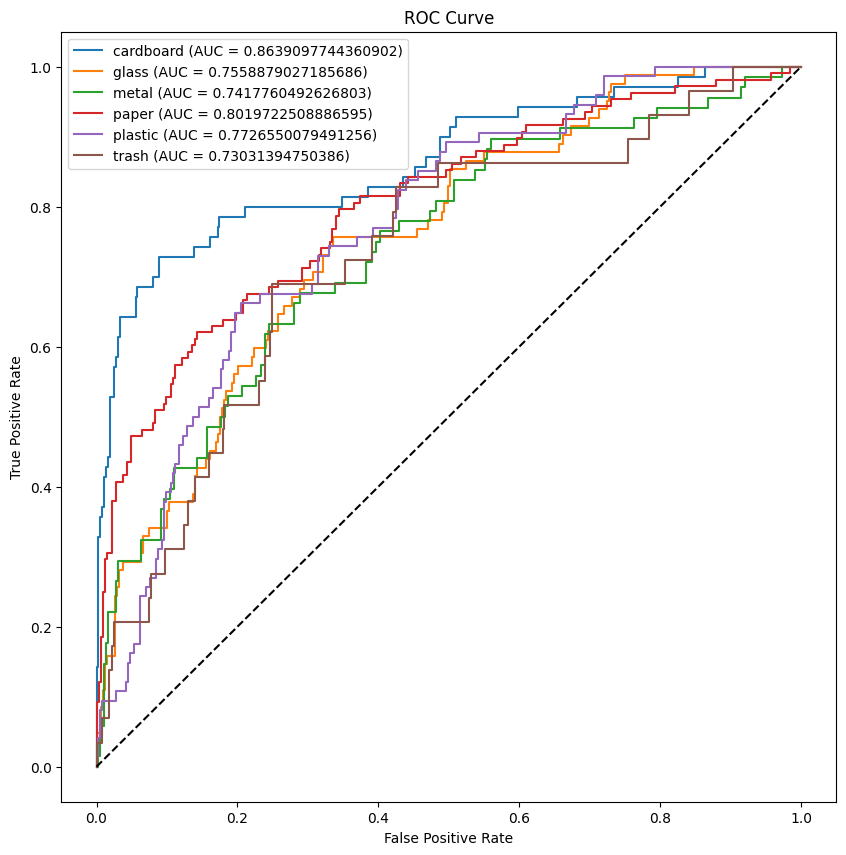

              precision    recall  f1-score   support

   cardboard       0.82      0.57      0.67        70
       glass       0.33      0.76      0.46        82
       metal       0.48      0.29      0.36        68
       paper       0.83      0.31      0.46       108
     plastic       0.38      0.57      0.46        74
       trash       0.00      0.00      0.00        29

    accuracy                           0.46       431
   macro avg       0.47      0.42      0.40       431
weighted avg       0.54      0.46      0.45       431



/media/alexandre/Secondary/Ubuntu/Projeto-CAA-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/alexandre/Secondary/Ubuntu/Projeto-CAA-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/alexandre/Secondary/Ubuntu/Projeto-CAA-1/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

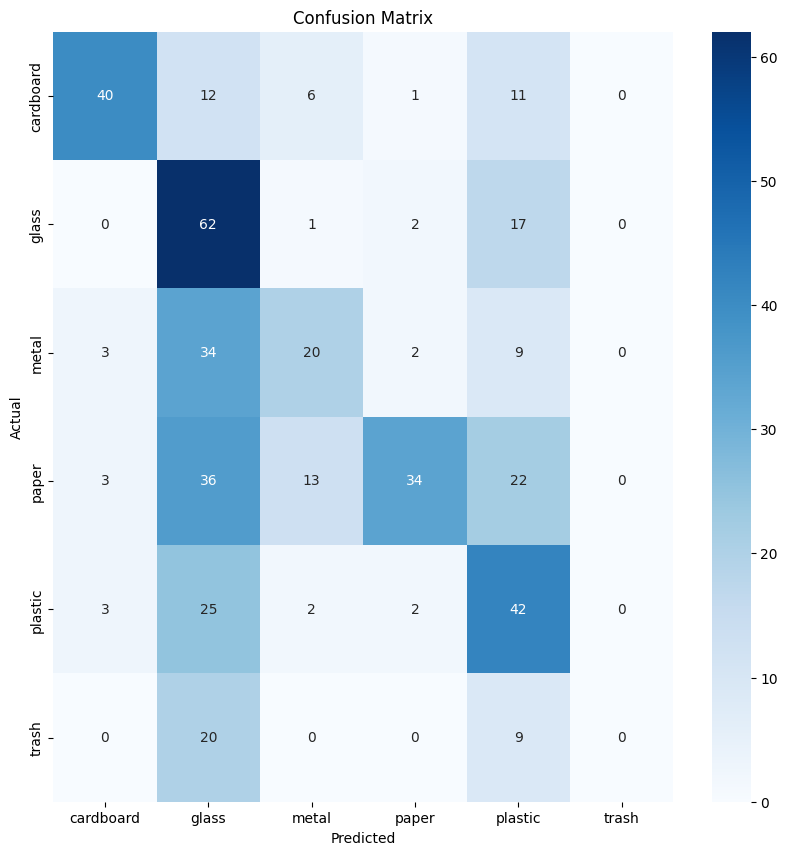

In [6]:
# Model Evaluation

# f1 score, precision, recall, accuracy, confusion matrix, classification report, and ROC curve

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc

# F1 Score
f1 = f1_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("F1 Score: ", f1)

# Precision
precision = precision_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("Precision: ", precision)

# Recall
recall = recall_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("Recall: ", recall)

# Accuracy
accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1))
print("Accuracy: ", accuracy)

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))

for i in range(6):
    plt.plot(fpr[i], tpr[i], label=classes_names[i] + ' (AUC = ' + str(roc_auc[i]) + ')')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

# Classification Report
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), target_names=classes_names))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


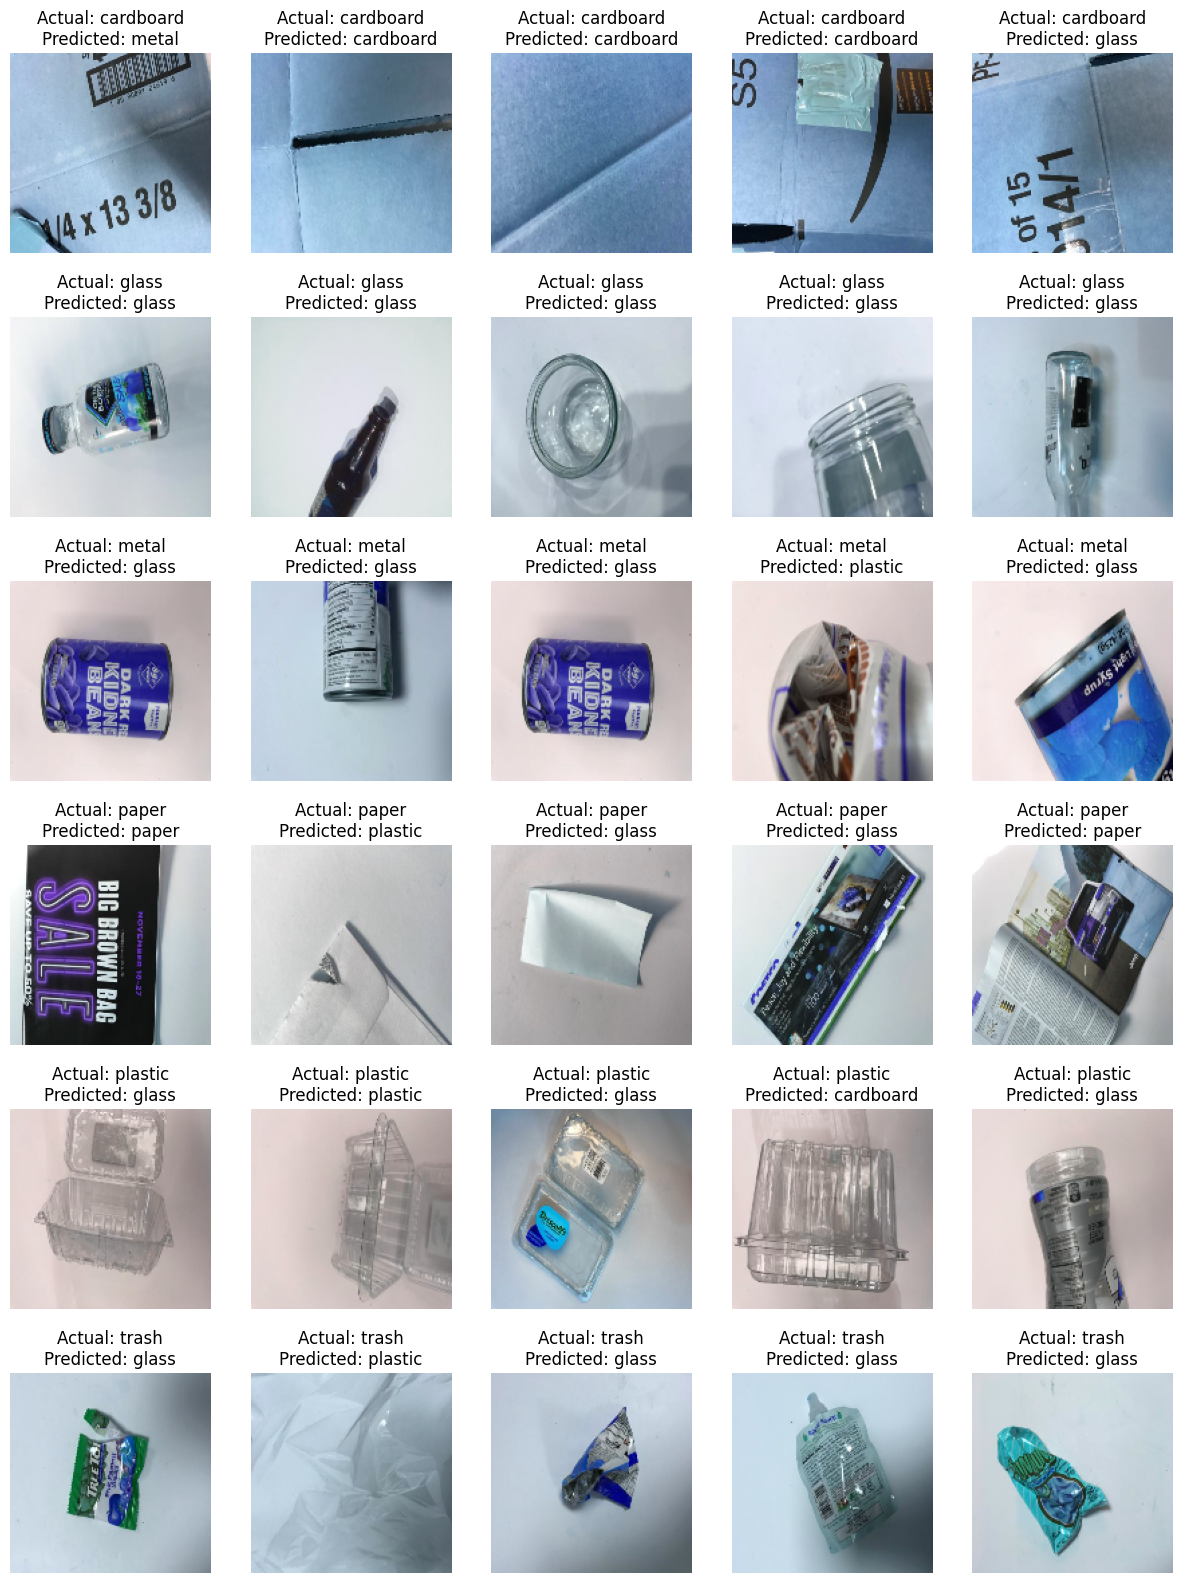

In [7]:
# Function to displaying random predictions from the dataset with their images and predictions

def display_random_predictions(X, y, predictions, classes_names, number_of_predictions=5):
    plt.figure(figsize=(15, 20))

    for class_name in classes_names:
        for i in range(number_of_predictions):
            index = np.random.choice(np.where(y == class_name)[0])
            plt.subplot(len(classes_names), number_of_predictions, number_of_predictions * list(classes_names).index(class_name) + i + 1)
            plt.imshow(X[index])
            plt.title("Actual: " + class_name + "\nPredicted: " + label_encoder.classes_[np.argmax(predictions[index])])
            plt.axis('off')
    
    plt.show()

display_random_predictions(X_test, y_test, predictions, classes_names)